In [1]:
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy.sparse import csr_matrix
import scanpy as sc
import os
from scipy.io import mmwrite
from tqdm import tqdm
import anndata
import anndata as ad
import pandas as pd
from collections import Counter

import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
import scipy

# 检查 scipy 的版本信息
print(scipy.__version__)

1.13.0


In [3]:
import anndata as ad
import scirpy as ir
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix

# Define paths and labels
tcr_paths = [
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_1_tumor_VDJ/SRR13737401_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_1_LNM_VDJ/SRR13737409_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_3_tumor_VDJ/SRR13737403_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_3_LNM_VDJ/SRR13737411_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_5_tumor_VDJ/SRR13737405_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_5_LNM_VDJ/SRR13737413_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_6_tumor_VDJ/SRR13737406_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_6_LNM_VDJ/SRR13737414_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_7_tumor_VDJ/SRR13737407_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_7_LNM_VDJ/SRR13737415_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_8_tumor_VDJ/SRR13737408_vdj/outs/filtered_contig_annotations.csv",
    "/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR/PT_8_LNM_VDJ/SRR13737416_vdj/outs/filtered_contig_annotations.csv"
]

labels = ["PT_1_tumor", "PT_1_LNM", "PT_3_tumor", "PT_3_LNM", "PT_5_tumor", "PT_5_LNM", "PT_6_tumor", "PT_6_LNM", "PT_7_tumor", "PT_7_LNM", "PT_8_tumor", "PT_8_LNM"]
patient_dirs = ["Patient1", "Patient1", "Patient3", "Patient3", "Patient5", "Patient5", "Patient6", "Patient6", "Patient7", "Patient7", "Patient8", "Patient8"]

# Map patient labels to new suffixes
patient_suffix_map = ['CA1_','LN1_','CA3_','LN3_','CA5_','LN5_','CA6_','LN6_','CA7_','LN7_','CA8_','LN8_']

# Initialize lists to store AnnData objects
adata_list = []
adata_tcr_list = []

# Load and process each sample
for i, tcr_path in enumerate(tcr_paths):
    patient_label = patient_dirs[i]
    suffix = patient_suffix_map[i]
    # Load TCR data
    adata_tcr = ir.io.read_10x_vdj(tcr_path)
    adata_tcr.obs_names = suffix + adata_tcr.obs_names.str.replace('-1$', '', regex=True)
    # Determine patient directory based on label
    patient_dir = f'/fs/ess/PAS1475/Maoteng/Metastasis/GSE167036/Patient_subsample/{patient_label}/'
    
    # 读取barcodes文件
    barcodes = pd.read_csv(patient_dir + 'barcodes.csv')
    # 读取features文件
    features = pd.read_csv(patient_dir + 'features.csv')
    # 读取cell_counts_matrix文件
    cell_counts_matrix = mmread(patient_dir + 'RNA_matrix.mtx')
    # 将coo_matrix转换为csr_matrix
    cell_counts_matrix_csr = csr_matrix(cell_counts_matrix)
    RNA_matrix = cell_counts_matrix_csr
    gene_names = list(features['x'])
    cell_names = list(barcodes['cell_id'])
    
    # 创建 AnnData 对象
    adata = ad.AnnData(RNA_matrix.transpose(), dtype='int32')
    adata.var_names = gene_names
    adata.obs_names = cell_names
    
    # 根据患者标签移除前缀并添加后缀
    if "PT_1" in labels[i]:
        adata.obs_names = suffix + adata.obs_names.str.replace('^CA1_', '', regex=True)
        adata.obs_names = adata.obs_names.str.replace('^LN1_', '', regex=True)
    elif "PT_3" in labels[i]:
        adata.obs_names = suffix + adata.obs_names.str.replace('^CA3_', '', regex=True)
        adata.obs_names = adata.obs_names.str.replace('^LN3_', '', regex=True)
    elif "PT_5" in labels[i]:
        adata.obs_names = suffix + adata.obs_names.str.replace('^CA5_', '', regex=True)
        adata.obs_names = adata.obs_names.str.replace('^LN5_', '', regex=True)
    elif "PT_6" in labels[i]:
        adata.obs_names = suffix + adata.obs_names.str.replace('^CA6_', '', regex=True)
        adata.obs_names = adata.obs_names.str.replace('^LN6_', '', regex=True)
    elif "PT_7" in labels[i]:
        adata.obs_names = suffix + adata.obs_names.str.replace('^CA7_', '', regex=True)
        adata.obs_names = adata.obs_names.str.replace('^LN7_', '', regex=True)
    elif "PT_8" in labels[i]:
        adata.obs_names = suffix + adata.obs_names.str.replace('^CA8_', '', regex=True)
        adata.obs_names = adata.obs_names.str.replace('^LN8_', '', regex=True)
    
    adata.obs_names_make_unique()
    adata_tcr.obs_names_make_unique()
    common_obs_names = adata.obs_names.intersection(adata_tcr.obs_names)
    
    adata = adata[common_obs_names].copy()
    adata_tcr = adata_tcr[common_obs_names].copy()
    
    # 添加标签
    adata_tcr.obs["label"] = labels[i]
    
    # 将处理好的对象添加到列表中
    adata_list.append(adata)
    adata_tcr_list.append(adata_tcr)

# 合并所有的 adata 和 adata_tcr
combined_adata = ad.concat(adata_list, axis=0)
combined_adata_tcr = ad.concat(adata_tcr_list, axis=0)

# 确保合并后的 obs_names 唯一
combined_adata.obs_names_make_unique()
combined_adata_tcr.obs_names_make_unique()

# 确认合并结果
print(combined_adata)
print(combined_adata_tcr)

mdata = mu.MuData({"gex": combined_adata, "airr": combined_adata_tcr})
mdata.obs["label"] = mdata['airr'].obs["label"]

/fs/ess/PAS1475/Maoteng/Conda_env/scirpy_env/lib/python3.9/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
/fs/ess/PAS1475/Maoteng/Conda_env/scirpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/fs/ess/PAS1475/Maoteng/Conda_env/scirpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/fs/ess/PAS1475/Maoteng/Conda_env/scirpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/fs/ess/PAS1475/Maoteng/Conda_env/scirpy_env/lib/python3.9/site-packages/anndata/_co

AnnData object with n_obs × n_vars = 31974 × 25301
AnnData object with n_obs × n_vars = 31974 × 0
    obs: 'label'
    obsm: 'airr'


#### 统计个样本比例

In [5]:
from collections import Counter
import pandas as pd


# 已有的 Counter 对象
counts = Counter(mdata.obs["label"])

# 指定患者ID的顺序
patients = ['PT_1', 'PT_3', 'PT_5', 'PT_6', 'PT_7', 'PT_8']

# 创建一个列表来保存数据
data = []

# 遍历每个患者ID，并提取 tumor 和 LNM 的计数
for patient in patients:
    tumor_count = counts.get(f'{patient}_tumor', 0)
    lnm_count = counts.get(f'{patient}_LNM', 0)
    data.append([patient, tumor_count, lnm_count])

# 计算总计
total_tumor_count = sum([row[1] for row in data])
total_lnm_count = sum([row[2] for row in data])

# 添加总计行
data.append(['Total', total_tumor_count, total_lnm_count])

# 转换为 DataFrame
counts_df = pd.DataFrame(data, columns=['Patient', 'Tumor_Count', 'LNM_Count'])

# 添加比例列，并保留两位小数
counts_df['Tumor_Proportion'] = (counts_df['Tumor_Count'] / (counts_df['Tumor_Count'] + counts_df['LNM_Count'])).round(3)
counts_df['LNM_Proportion'] = (counts_df['LNM_Count'] / (counts_df['Tumor_Count'] + counts_df['LNM_Count'])).round(3)

# 打印 DataFrame
counts_df

Patient  Tumor_Count  LNM_Count  Tumor_Proportion  LNM_Proportion
0    PT_1         3990       1779             0.692           0.308
1    PT_3         1613       2400             0.402           0.598
2    PT_5         1983       3244             0.379           0.621
3    PT_6         3712       4188             0.470           0.530
4    PT_7         1571       3020             0.342           0.658
5    PT_8         3005       1469             0.672           0.328
6   Total        15874      16100             0.496           0.504

#### 对免疫受体数据进行质量控制、距离计算、克隆群体定义

In [6]:
mdata.obs["patient_id"] = mdata.obs["label"].str.replace('_', '', n=1).str.split('_').str[0]
mdata.obs["location"] = mdata.obs["label"].str.replace('_', '', n=1).str.split('_').str[1].str.replace('t', 'T', n=1)

sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

ir.pp.ir_dist(mdata, metric="alignment", sequence="aa", cutoff=5)

ir.tl.define_clonotype_clusters(
    mdata,
    metric="alignment",
    sequence="aa",
    receptor_arms="any",
    dual_ir="primary_only",
)

computing PCA
    with n_comps=50
    finished (0:00:31)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:26)
computing UMAP
    finished (0:00:31)
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


In [16]:
mdata.obs

airr:label       label patient_id location  \
CA1_AAACCTGAGAGGTAGA  PT_1_tumor  PT_1_tumor        PT1    Tumor   
CA1_AAACCTGAGCCCAACC  PT_1_tumor  PT_1_tumor        PT1    Tumor   
CA1_AAACCTGAGTCCGTAT  PT_1_tumor  PT_1_tumor        PT1    Tumor   
CA1_AAACCTGCAAGTAATG  PT_1_tumor  PT_1_tumor        PT1    Tumor   
CA1_AAACCTGCAGCGATCC  PT_1_tumor  PT_1_tumor        PT1    Tumor   
...                          ...         ...        ...      ...   
LN8_TTTGGTTTCACAGTAC    PT_8_LNM    PT_8_LNM        PT8      LNM   
LN8_TTTGTCAAGTGTACCT    PT_8_LNM    PT_8_LNM        PT8      LNM   
LN8_TTTGTCACATGAGCGA    PT_8_LNM    PT_8_LNM        PT8      LNM   
LN8_TTTGTCACATTACGAC    PT_8_LNM    PT_8_LNM        PT8      LNM   
LN8_TTTGTCATCATTTGGG    PT_8_LNM    PT_8_LNM        PT8      LNM   

                     airr:receptor_type airr:receptor_subtype  \
CA1_AAACCTGAGAGGTAGA                TCR               TRA+TRB   
CA1_AAACCTGAGCCCAACC                TCR               TRA+TRB   
CA1_AAACCTGAGTCCGTAT                TCR               TRA+TRB   
CA1_AAACCTGCAAGTAATG                TCR               TRA+TRB   
CA1_AAACCTGCAGCGATCC                TCR               TRA+TRB   
...                                 ...                   ...   
LN8_TTTGGTTTCACAGTAC                TCR               TRA+TRB   
LN8_TTTGTCAAGTGTACCT                TCR               TRA+TRB   
LN8_TTTGTCACATGAGCGA                TCR               TRA+TRB   
LN8_TTTGTCACATTACGAC                TCR               TRA+TRB   
LN8_TTTGTCATCATTTGGG                TCR               TRA+TRB   

                     airr:chain_pairing airr:cc_aa_alignment  \
CA1_AAACCTGAGAGGTAGA        single pair                    0   
CA1_AAACCTGAGCCCAACC        single pair                    1   
CA1_AAACCTGAGTCCGTAT        single pair                    2   
CA1_AAACCTGCAAGTAATG        single pair                    3   
CA1_AAACCTGCAGCGATCC        single pair                    4   
...                                 ...                  ...   
LN8_TTTGGTTTCACAGTAC         orphan VDJ                13749   
LN8_TTTGTCAAGTGTACCT        single pair                13338   
LN8_TTTGTCACATGAGCGA    two full chains                13750   
LN8_TTTGTCACATTACGAC        single pair                13751   
LN8_TTTGTCATCATTTGGG        single pair                   25   

                      airr:cc_aa_alignment_size  
CA1_AAACCTGAGAGGTAGA                        175  
CA1_AAACCTGAGCCCAACC                          3  
CA1_AAACCTGAGTCCGTAT                         16  
CA1_AAACCTGCAAGTAATG                          1  
CA1_AAACCTGCAGCGATCC                        567  
...                                         ...  
LN8_TTTGGTTTCACAGTAC                          1  
LN8_TTTGTCAAGTGTACCT                          3  
LN8_TTTGTCACATGAGCGA                          1  
LN8_TTTGTCACATTACGAC                          1  
LN8_TTTGTCATCATTTGGG                       5105  

[31974 rows x 9 columns]

#### 绘制clonotype_network

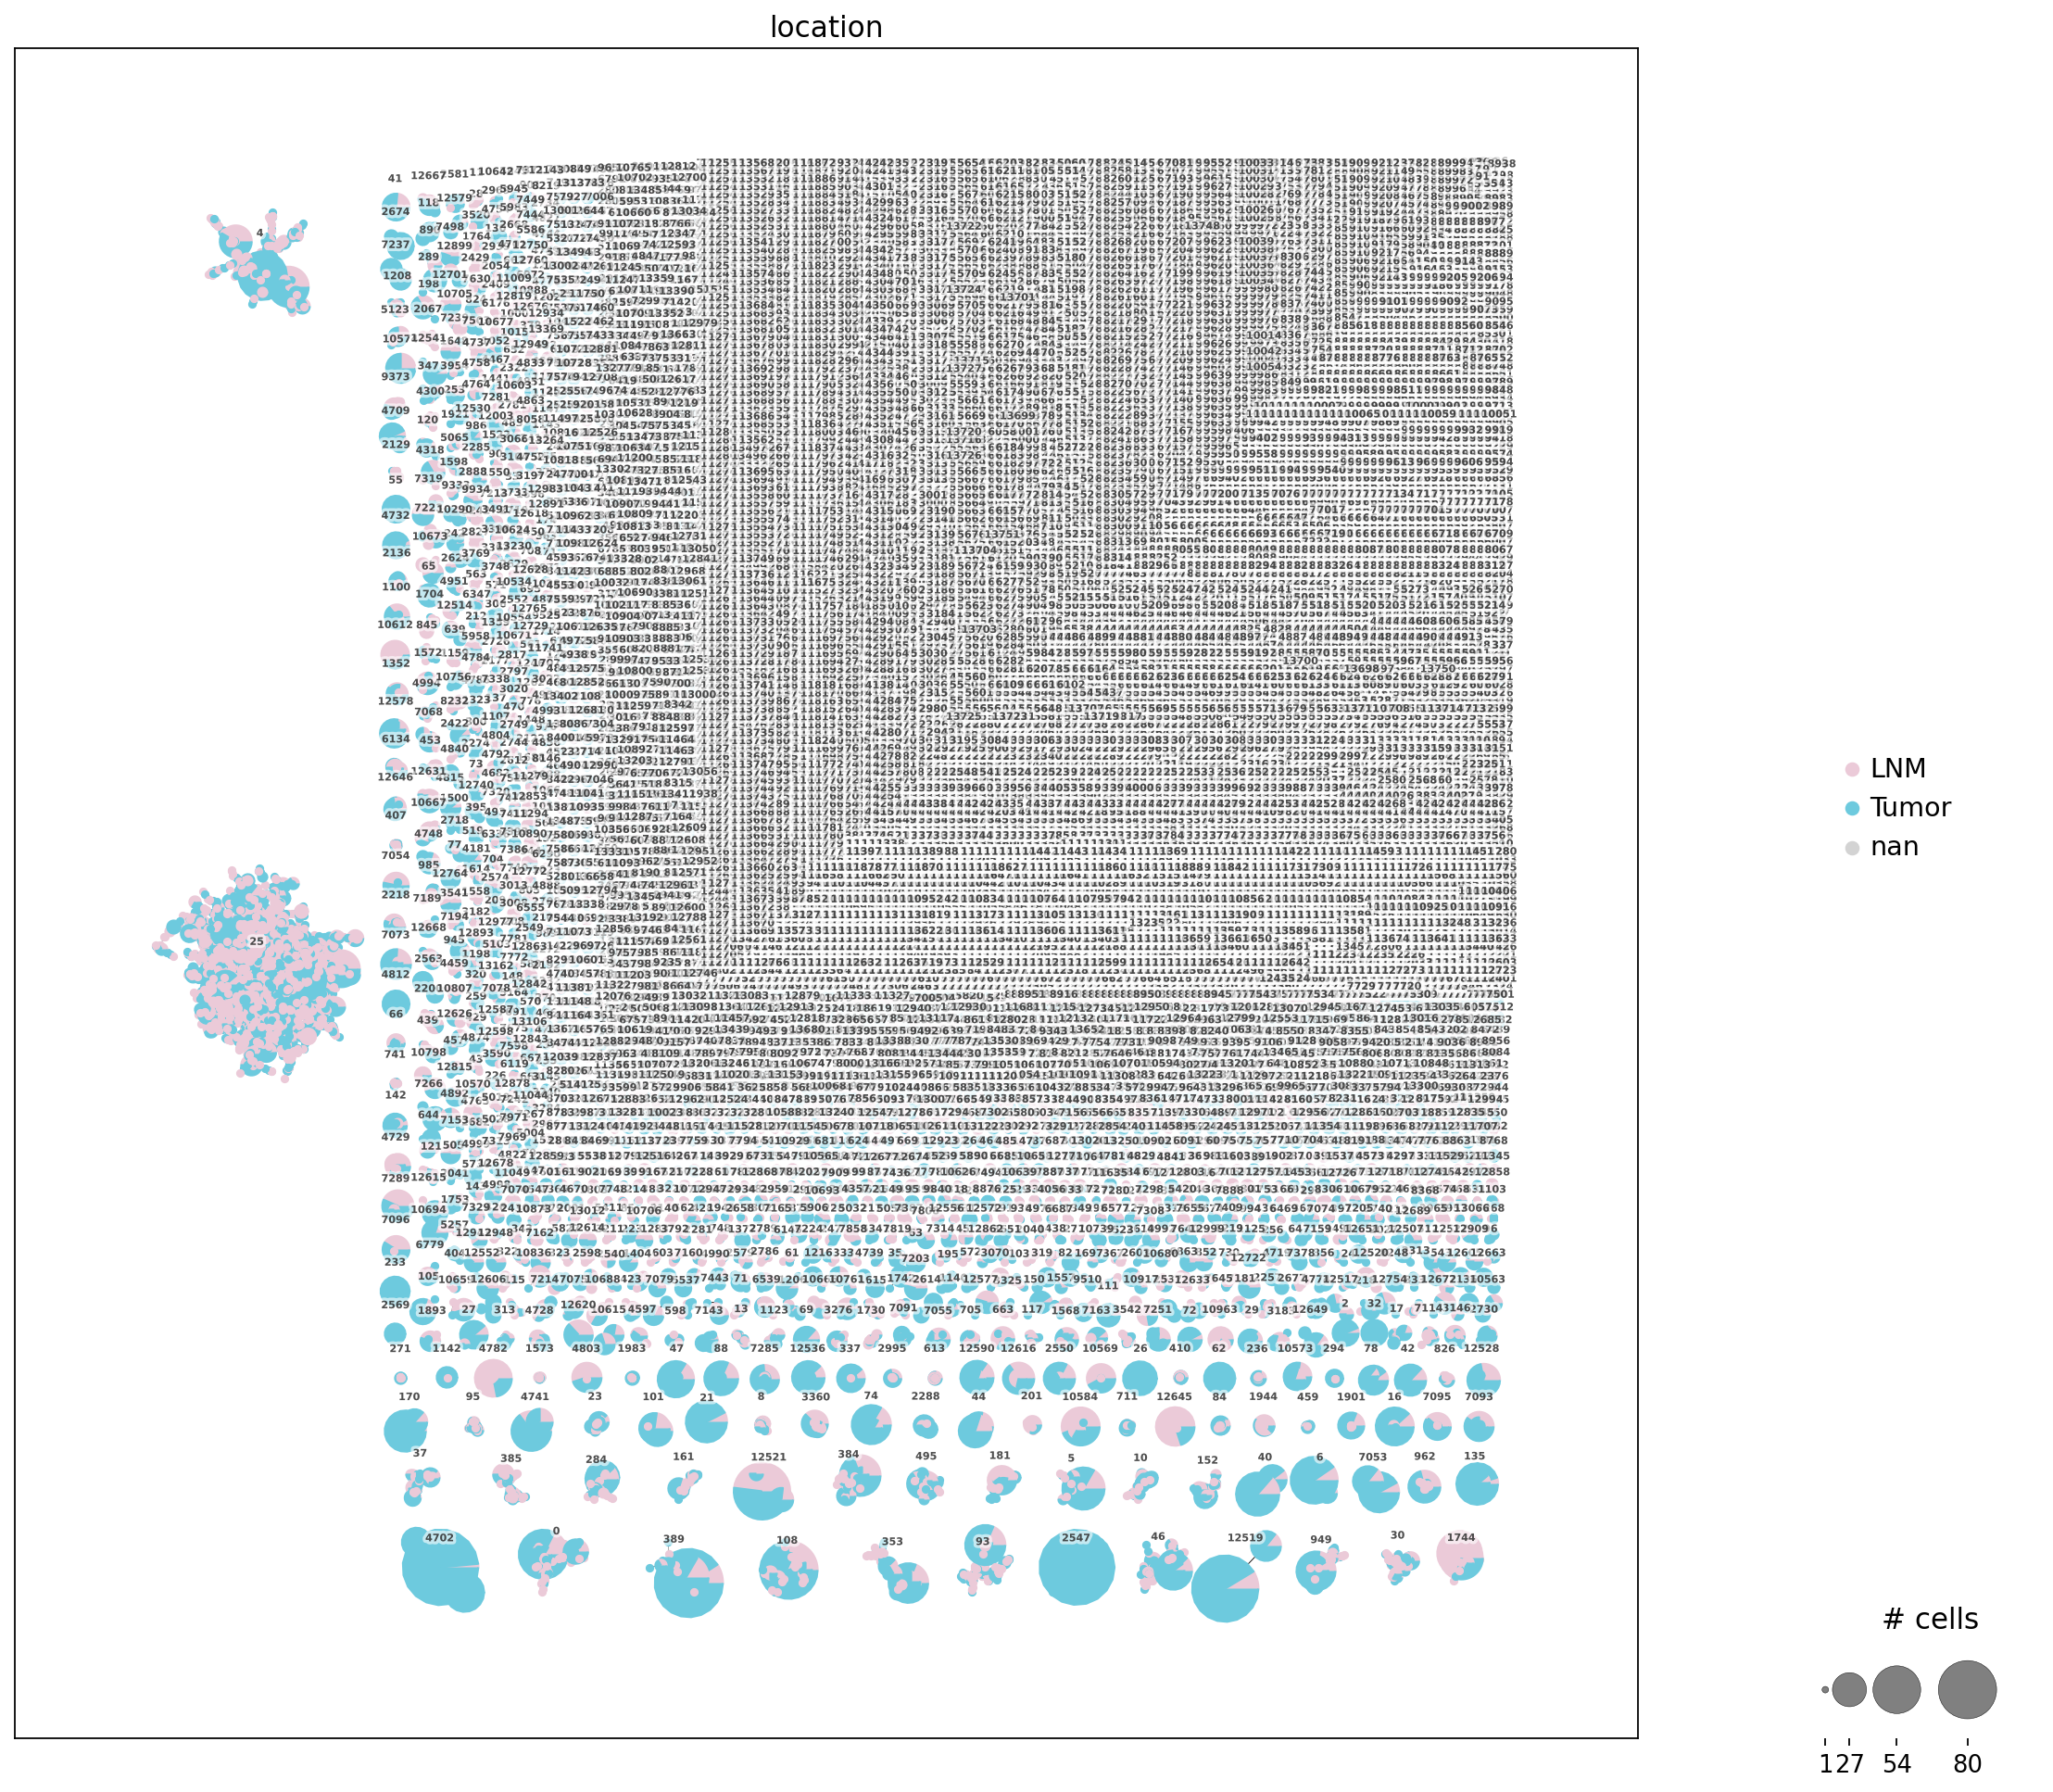

In [9]:
import matplotlib.pyplot as plt
import scirpy as ir
os.chdir('/fs/ess/PAS1475/Maoteng/Metastasis_new/GSE167036/TCR')

ir.tl.clonotype_network(mdata, size_aware=False, metric="alignment", sequence="aa")

# 调整点和标签的大小，并增大画布尺寸
ax = ir.pl.clonotype_network(
    mdata,
    color="location",
    base_size=10,        # 减小点的大小
    label_fontsize=5,    # 减小标签的大小
    panel_size=(15, 15),  # 增大画布的尺寸
    palette={"LNM": "#EBCAD8", "Tumor": "#6DCADE"} # 设置特定标签的颜色
)

# 保存图像为PNG格式
# plt.savefig("clonotype_network.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

#### 免疫基因UMAP可视化

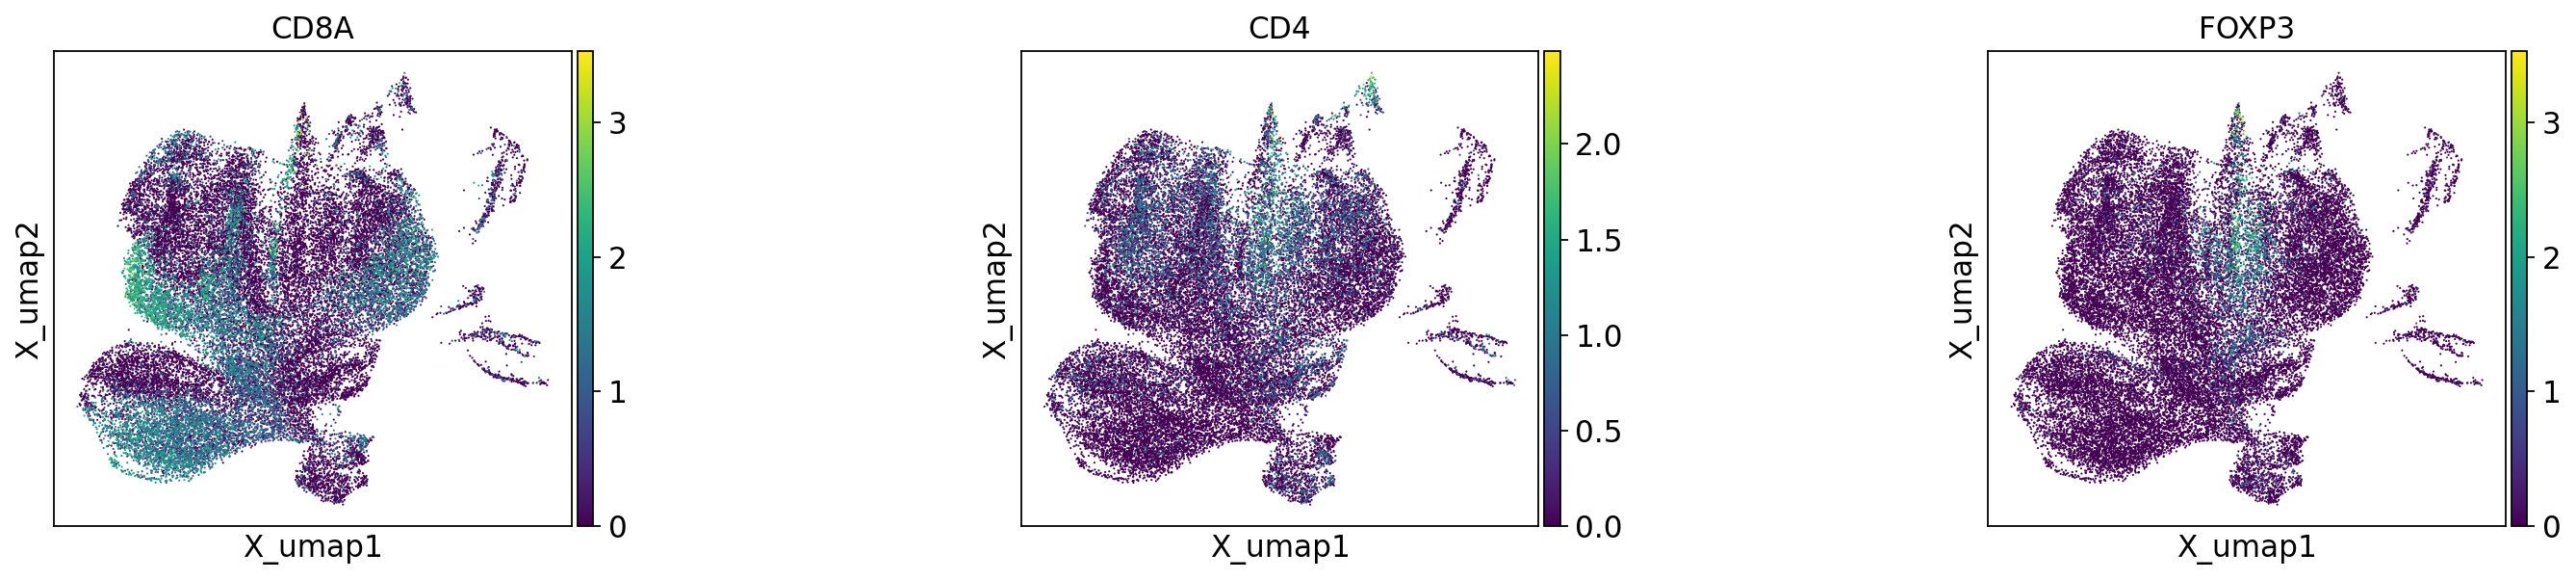

running Leiden clustering


/tmp/slurmtmp.33165751/ipykernel_178765/2620706223.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata["gex"],resolution=0.5)


    finished (0:00:26)


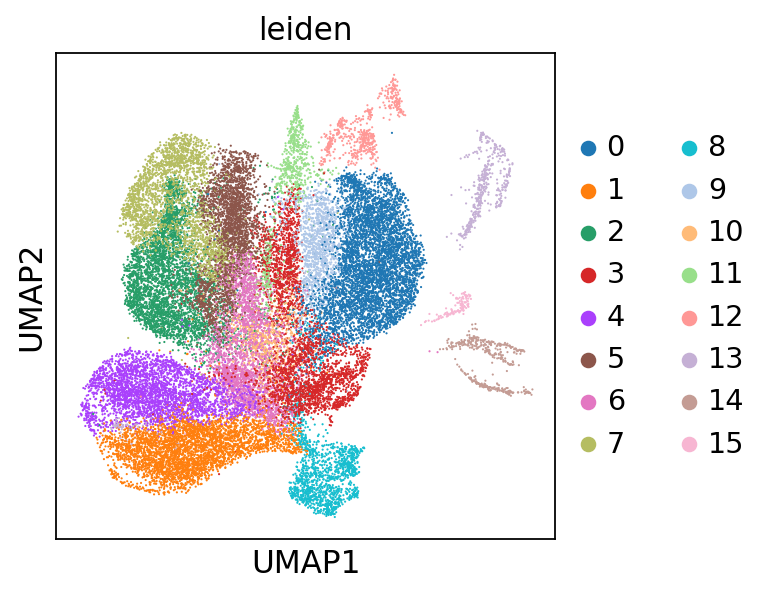

In [11]:
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["CD8A", "CD4", "FOXP3"],
    ncols=3,
    wspace=0.7,
)

# 运行Leiden聚类
sc.tl.leiden(mdata["gex"],resolution=0.5)

# 绘制UMAP图
sc.pl.umap(mdata["gex"], color=["leiden"])
plt.show()

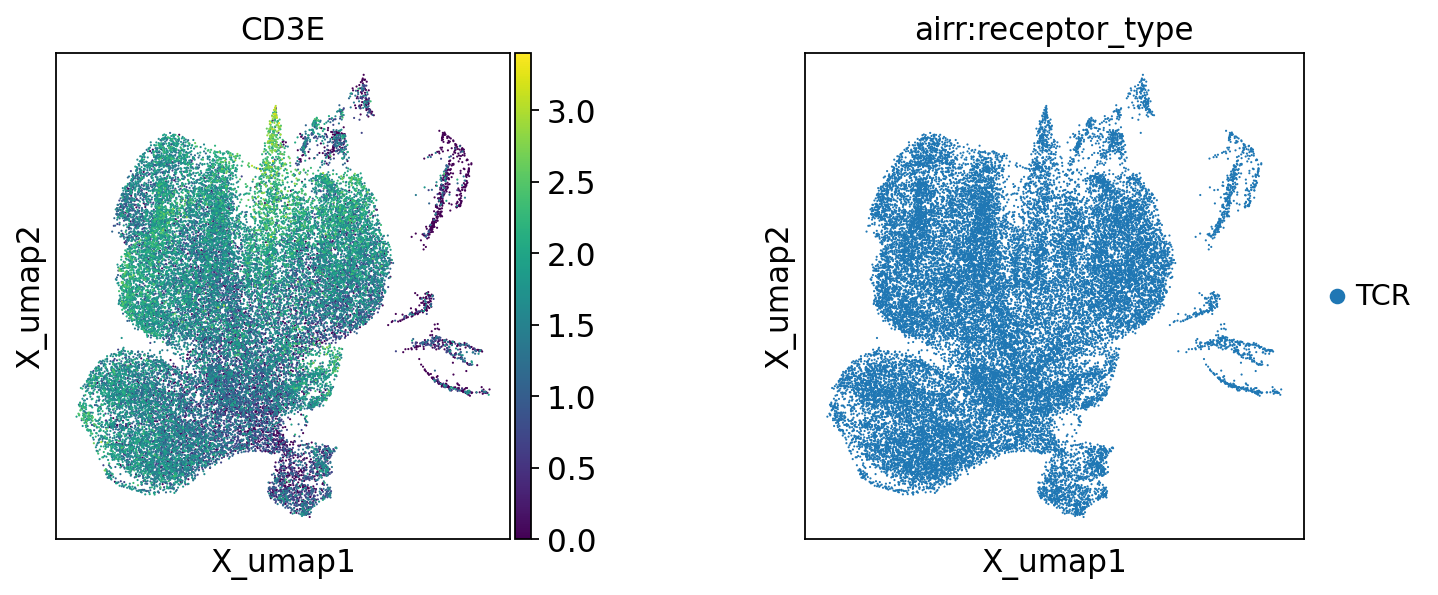

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

#### 免疫受体链配对的丰度分布

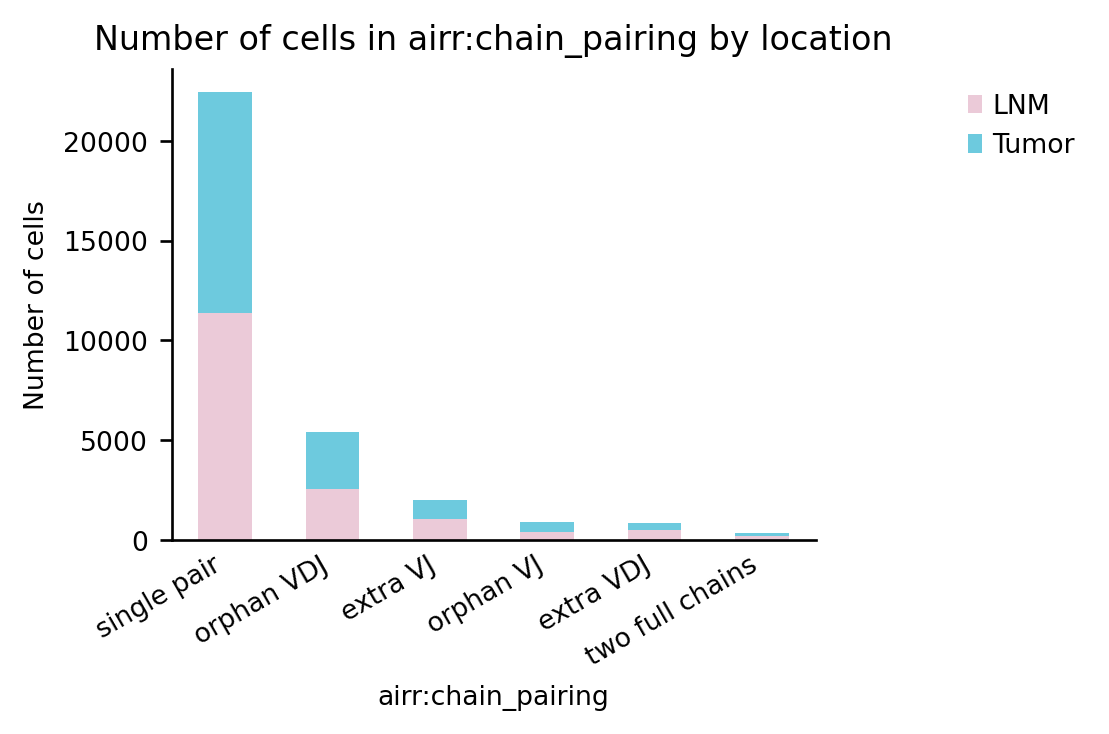

In [13]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="location")

####  绘制免疫克隆扩展图

In [17]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


  0%|          | 0/23218 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.


<Figure size 2000x1280 with 0 Axes>

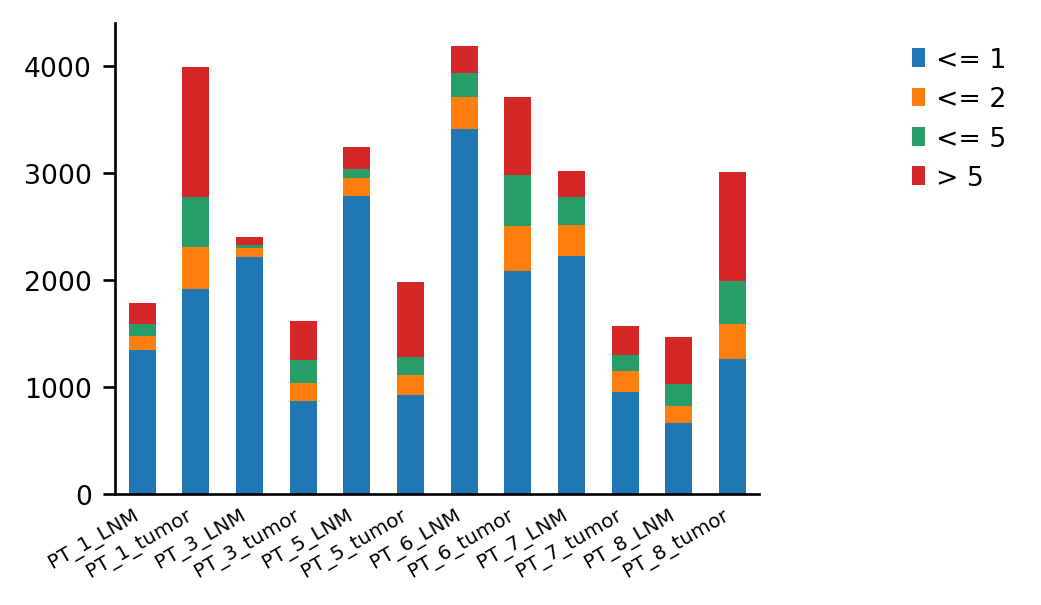

In [18]:
import matplotlib.pyplot as plt
import scirpy as ir

# 设置画布大小
plt.figure(figsize=(25, 16))

# 调用 scirpy 的 clonal_expansion 绘图函数
ir.pl.clonal_expansion(mdata, target_col="clone_id", groupby="label", breakpoints=(1, 2, 5), normalize=False)

# 设置 x 轴标签的字体大小
plt.xticks(fontsize=6)  # 你可以根据需要调整字体大小

# 显示图形
plt.show()

/fs/ess/PAS1475/Maoteng/Conda_env/scirpy_env/lib/python3.9/site-packages/scirpy/util/__init__.py:458: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


<Figure size 2000x1280 with 0 Axes>

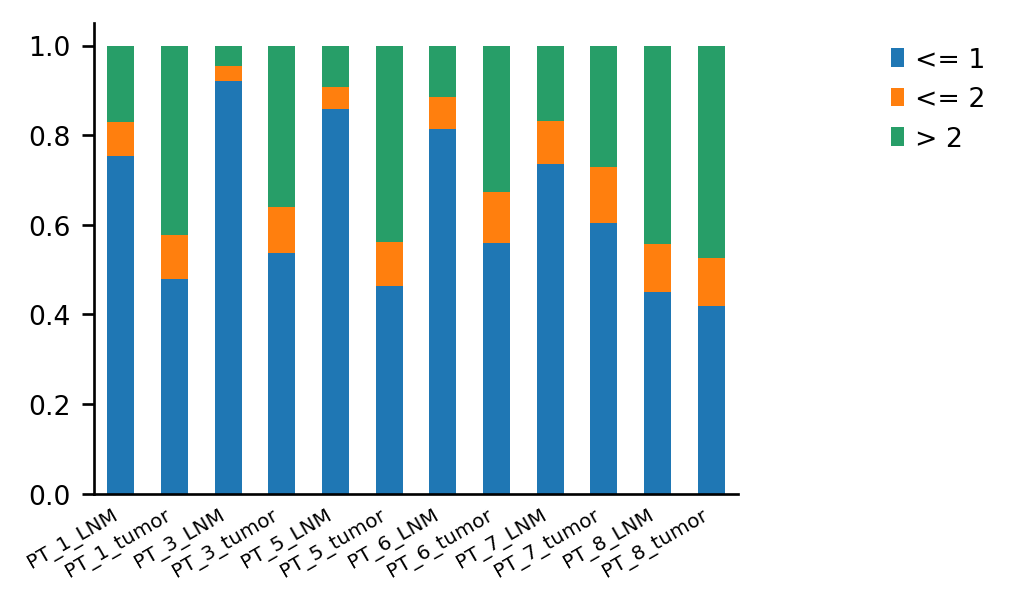

In [19]:
import matplotlib.pyplot as plt
import scirpy as ir

# 设置画布大小
plt.figure(figsize=(25, 16))

# 调用 scirpy 的 clonal_expansion 绘图函数
ir.pl.clonal_expansion(mdata, target_col="clone_id", groupby="label")

# 设置 x 轴标签的字体大小
plt.xticks(fontsize=6)  # 你可以根据需要调整字体大小

# 显示图形
plt.show()